In [2]:
# from pre_processing.utils import BaseDataFactory
#
# BaseDataFactory.get_ladder_codes()
# data = BaseDataFactory.factory(3, '28-02-16 to 2018-12-19', fix_duplicates=True, save=True)

import numpy as np
import pandas as pd
import os

import numpy as np
import pandas as pd


def returns_deacs_strings_before_or_after_ladder_out(agg, sensor_data):
    """
    This function provides insights into when deactivations occur during
    the lifecycle of a ladder. In the time period between one ladder exiting
    the machine and the next ladder exiting, each string is numbered in
    descending order. A fill forward fillna strategy is used to create groups.
    When the sensor data is sliced to contain only rows with deactivations,
    each row will therefore have a value for the number of strings left before
    the next ladder comes out
    """

    """
    Removes all 0102 IDs that occur after the last ladder has exited. Except 
    for the first if it exists 
    """
    condition = (agg['0103 ID'] < 1) & (agg['strings until next ladder'] > 1)
    condition = agg['0102 ID'].isin(
        agg.loc[condition, '0102 ID']
    )
    agg = agg[~condition]

    """
    Keeps all the rows of the sensor data which have the same 0102 IDs as the
    agg data
    """
    ids = agg.loc[condition, '0102 ID']
    condition_2 = sensor_data['0102 ID'].isin(ids)
    sensor_data = sensor_data[~condition_2]

    """
    Numbers each string-in based on how many strings are yet to enter the
    machine before the next ladder exits 
    """

    non_dups = sensor_data[sensor_data['Non Duplicate 0102'] == 1].copy()
    groupby = non_dups.groupby('0103 ID')
    sensor_data['strings until next ladder'] = groupby\
        .cumcount(ascending=False) + 1
    sensor_data['strings since last ladder'] = groupby.cumcount() + 1

    groupby = sensor_data.groupby('JOBNUM')
    sensor_data['0102 ID'] = groupby['0102 ID'].fillna(method='bfill')

    """
    Sets the value of 'rows until end' to 0 for rows that occur after 
    a ladder has exited and before the next string enters the machine
    """
    condition = sensor_data['Non Duplicate 0103'] == 1
    indices = sensor_data.loc[condition].index
    sensor_data.loc[indices, 'strings until next ladder'] = 0
    sensor_data.loc[indices, 'strings since last ladder'] = 0
    groupby = sensor_data.groupby('JOBNUM')

    sensor_data['strings until next ladder'] = groupby['strings until next ladder']\
        .fillna(method='ffill')
    sensor_data['strings since last ladder'] = groupby['strings since last ladder']\
        .fillna(method='ffill')

    """
    Removes excess columns
    """
    columns = [
        'Date', 'JOBNUM', '0103 non_unique ID', '0102 ID', '0103 ID',
        'Non Duplicate 0101', 'Non Duplicate 0102', 'Non Duplicate 0103',
        'strings until next ladder', 'strings since last ladder'
    ]
    sensor_data = sensor_data[columns]

    """
    Slices the sensor data to leave only rows that contain deactivations
    and a '0103 non_unique ID' value that is greater than 1. The second
    part of the condition removes rows that occur at the start of a
    JOBNUM. This is because the start of JOBNUMs are not representative
    of most of the data. Many strings enter and no ladders exit. 
    """
    condition = (sensor_data['Non Duplicate 0101'] == 1) & \
                (sensor_data['0103 non_unique ID'] > 1)
    return sensor_data[condition].dropna(), sensor_data


def returns_non_deacs_time_delta_zero_group(sensor_data, agg):
    """
    calculates the time difference between when a ladder exits the machine
    and the next string enters when there are no deactivations
    """
    zeros = sensor_data[sensor_data['strings since last ladder'] == 0].copy()
    ids_to_delete = zeros.loc[zeros['Non Duplicate 0101'] == 1, '0102 ID']
    non_deacs_zeros = zeros[~zeros['0102 ID'].isin(ids_to_delete)]
    non_deacs_zeros['Duplicate Index'] = non_deacs_zeros.index

    non_deacs = non_deacs_zeros.groupby('0102 ID').agg(
        {'Duplicate Index': 'first', '0102 ID': 'first', 'Date': ['first', 'last']}
    )
    non_deacs.columns = ['Duplicate Index', '0102 ID', 'start', 'end']
    non_deacs = non_deacs.set_index('Duplicate Index', drop=True)

    non_deacs['start'] = pd.to_datetime(non_deacs['start'])
    non_deacs['end'] = pd.to_datetime(non_deacs['end'])
    non_deacs['ND 0 time delta'] = (non_deacs['end'] - non_deacs['start']).dt \
        .total_seconds() \
        .astype(int)

    agg['ND 0 time delta'] = non_deacs['ND 0 time delta']
    return agg


def confusion_matrix(agg, n=25, train=True):
    columns = ['0102 Pace', 'Label', '0102 ID']
    agg[[f'next_{column}' for column in columns]] = agg.groupby('JOBNUM')[columns].shift(-1)

    """
    Some Deactivations spill into the next 0102 ID. The following two conditions remove
    these rows to prevent them distorting the confusion matrix
    """
    over_flow_condition = (agg['Label'] == 1) & \
                          (agg['0101 Duration'] + agg['Time Delta'] > agg['0102 Pace']) & \
                          (agg['next_Label'] == 0) & \
                          (agg['next_0102 Pace'] >= n)

    false_neg_condition = (agg['0102 Pace'] >= n) & \
                          (agg['Label'] == 0) & \
                          (agg['0102 ID'].isin(agg.loc[~over_flow_condition, 'next_0102 ID']))

    true_pos = len(agg.loc[agg.loc[:, 'Label'] == 0].index)
    false_neg = len(agg[false_neg_condition].index)
    true_neg = len(agg.loc[(agg.loc[:, 'Time Delta'] >= n) & (agg.loc[:, 'Label'] == 1)].index)
    false_pos = len(agg.loc[(agg.loc[:, 'Time Delta'] < n) & (agg.loc[:, 'Label'] == 1)].index)
    if train:
        true_pos = round(true_pos / 5)
        false_neg = round(false_neg / 5)
        false_pos = round(false_pos / 5)
        true_neg = round(true_neg / 5)
    return np.array(
        [[true_pos, false_neg],
         [false_pos, true_neg]]
    )


def corr(percentiles):
    a = percentiles[['ND: 0102 Pace']]
    a['Label'] = 0
    a.columns = ['Time', 'Label']

    b = percentiles[['D: time delta']]
    b['Label'] = 1
    b.columns = ['Time', 'Label']
    return pd.concat([a, b], axis=0, sort=False).corr().iloc[1, 0]

path = r'/home/james/Development/DolleProject/dolle_csvs/' \
       r'28-02-16 to 2018-12-19/Stats 1405: 0102, 1 SW, 2 CF, ' \
       r'no overlaps/'

p_sensor_data = pd.read_csv(os.path.join(path, r'sensor_data.csv'), sep=',')

agg = pd.read_csv(os.path.join(path, r'all 3 products/all 3 products.csv'), sep=',')

# import matplotlib.pyplot as plt
#
# b = pd.DataFrame(
#     np.percentile(agg['Time Delta'].dropna(), [i for i in range(0, 110, 10)]),
#     [f'{i}%' for i in range(0, 110, 10)]
# )
#
# b.iloc[0, 0] = 1
# b.iloc[1, 0] = 1
#
# plt.plot(np.log(b), label='Time delta between last string and deactivation')
# plt.axhline(
#     y=np.log10(8), color='r', linestyle='-', label='Median String In Pace'
# )
# plt.ylabel('log 10 time difference')
# plt.xlabel('Percentage of Deactivations')
# plt.legend(loc='upper left')
# plt.show()


/home/james/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0, 0.5, 'Time (s)')

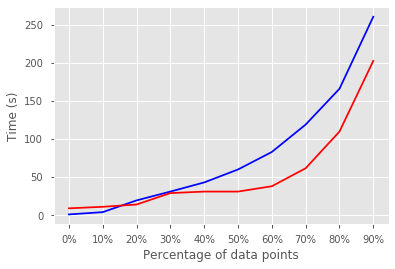

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('ggplot')

deacs, sensor_data = returns_deacs_strings_before_or_after_ladder_out(
    agg, p_sensor_data
)
a = agg[['0102 ID', 'Time Delta']].dropna()
deacs = deacs.merge(right=a, left_on='0102 ID', right_on='0102 ID', how='left')
single_deacs = deacs[deacs.groupby('0102 ID').cumcount() == 0]

b = pd.DataFrame(
    np.percentile(single_deacs['Time Delta'].dropna(), [i for i in range(0, 100, 10)]),
    [f'{i}%' for i in range(0, 100, 10)]
)
b.iloc[0, 0] = 1
c = returns_non_deacs_time_delta_zero_group(sensor_data, agg)
c = c[c['ND 0 time delta'] > 8]
c = pd.DataFrame(
    np.percentile(c['ND 0 time delta'].dropna(), [i for i in range(0, 100, 10)]),
    [f'{i}%' for i in range(0, 100, 10)]
)
plt.plot(b, color='b')
plt.plot(c, color='r')
plt.xlabel('Percentage of data points')
plt.ylabel('Time (s)')